In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from PIL.Image import LANCZOS
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
num_epochs = 15
batch_size = 100
learning_rate = 0.001

In [ ]:
# Mnist dataset
train_dataset = datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.Compose([
                                                    transforms.ToTensor()
                                           ]),
                                           download=True)
  


test_dataset = datasets.MNIST(root='../../data', 
                                            train=False, 
                                            transform=transforms.Compose([
                                                      transforms.ToTensor()
                                            ]),
                                            download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=32*32):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=200, z_dim=32, n_hidden=100):
        super(VAE, self).__init__()
        self.encoder = self.net = nn.Sequential(
            nn.Linear(28*28, n_hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(n_hidden, h_dim)
          )
        
        self.fc1 = nn.Linear(h_dim, z_dim)#32
        self.fc2 = nn.Linear(h_dim, z_dim)#32
        #self.fc3 = nn.Linear(z_dim, h_dim)#1024
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(h_dim, n_hidden),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(n_hidden,28*28),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        #(batch,32)

        # return torch.normal(mu, std)
        # [*] is used as size can vary
        esp = torch.randn(*mu.size()).to(device)
        #(batch,32)

        z = mu + std * esp
        #(batch,32)
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        #(batch,32),(batch,32)

        z = self.reparameterize(mu, logvar)
        #(batch,32)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #(batch,1024)

        z, mu, logvar = self.bottleneck(h)
        #(all are (batch,32))

        return z, mu, logvar

    def decode(self, z):
        #z = self.fc3(z)
        #(batch,1024)

        z = self.decoder(z)
        #(batch,1,64,64)

        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        #(all are (batch,32))

        z = self.decode(z)
        #(batch,1,64,64)

        return z, mu, logvar
        #(batch,1,64,64),(batch,32),(batch,32)

def binary_cross_entropy(x, y):

    loss1 = nn.BCELoss(reduction='sum')
    return loss1(x,y)


def loss_function(recon_x, x, mu, logvar):
    BCE = binary_cross_entropy(recon_x, x)

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
# Train the model
a_factor=0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        z, mu, logvar = model(images)
        loss = loss_function(z,images,mu,logvar)
        BCE_loss = binary_cross_entropy(z,images)
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], KLD_Loss: {:.4f}, BCE_Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()-BCE_loss.item(),BCE_loss.item()))


Epoch [1/15], Step [100/600], KLD_Loss: 0.2988, BCE_Loss: 22018.8672
Epoch [1/15], Step [200/600], KLD_Loss: 0.7578, BCE_Loss: 19712.2305
Epoch [1/15], Step [300/600], KLD_Loss: 1.3457, BCE_Loss: 19153.5234
Epoch [1/15], Step [400/600], KLD_Loss: 2.0371, BCE_Loss: 19203.7871
Epoch [1/15], Step [500/600], KLD_Loss: 4.1816, BCE_Loss: 17794.5410
Epoch [1/15], Step [600/600], KLD_Loss: 5.3711, BCE_Loss: 17806.0391
Epoch [2/15], Step [100/600], KLD_Loss: 7.8281, BCE_Loss: 18005.9199
Epoch [2/15], Step [200/600], KLD_Loss: 8.5742, BCE_Loss: 16965.1680
Epoch [2/15], Step [300/600], KLD_Loss: 8.2754, BCE_Loss: 16896.2812
Epoch [2/15], Step [400/600], KLD_Loss: 9.6729, BCE_Loss: 16262.9590
Epoch [2/15], Step [500/600], KLD_Loss: 7.5059, BCE_Loss: 16972.2402
Epoch [2/15], Step [600/600], KLD_Loss: 10.7227, BCE_Loss: 16987.3125
Epoch [3/15], Step [100/600], KLD_Loss: 12.0566, BCE_Loss: 16998.3730
Epoch [3/15], Step [200/600], KLD_Loss: 8.1758, BCE_Loss: 16991.8047
Epoch [3/15], Step [300/600], KL

In [ ]:
z=torch.randn((25,32)).to(device)
rec=model.decoder(z).to('cpu').detach()
rec[0].shape

torch.Size([784])

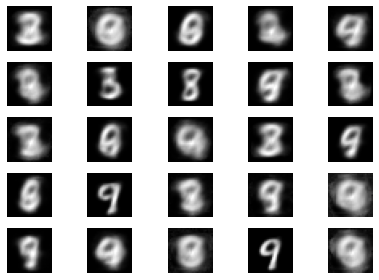

In [ ]:
cnt=0

for i in range(5):
  for j in range(5):
    cnt+=1
    plt.subplot(5,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(np.reshape(rec[cnt-1], [28, 28]), cmap='gray')
    plt.axis("off")
plt.tight_layout()    
plt.show()